# Analysis: Logistic Regression for Profitability

Goal: Use logistic regression to create a model for the profitability feature.

In [35]:
import pandas as PD
import numpy as NP

import sklearn.preprocessing as PP
import imblearn.pipeline as PL
import sklearn.model_selection as MS
import imblearn.under_sampling as US
import imblearn.over_sampling as OS

import sklearn.linear_model as LM
import sklearn.metrics as MT     # roc_auc_score, roc_curve, auc

import matplotlib.pyplot as MP
import seaborn as SB
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Prepare Target & Features

In [3]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = PD.read_csv(FEATURE_FILE)
full_df.head()
full_df.info()

,set_no,name,price_store,price_used,year,volume,weight,number_parts,total_parts,number_spare_parts,...,windscreens_and_fuselage_tot_prts,znap_tot_prts,category,scolor_1st,scolor_2nd,popularity,aftermarket,adj_store_price,adj_aftermarket,profitable
0,15-1,Castle Minifigures,NaN,63.0,1984,NaN,NaN,16,38,0,...,0,0,Historical,Gray,Black,NaN,NaN,NaN,NaN,NaN
1,105-1,Mail Van,NaN,102.0,1984,NaN,NaN,34,65,0,...,1,0,Modern-Town,Red,White,4.0,NaN,NaN,NaN,NaN
2,3639-1,Paddy Wagon,NaN,14.0,1984,NaN,NaN,11,12,0,...,0,0,Bigfig-Junior,Blue,Black,NaN,NaN,NaN,NaN,NaN
3,3664-1,Bertie Bulldog (Police Chief) and Constable Bu...,NaN,31.0,1984,NaN,NaN,24,63,0,...,0,0,Bigfig-Junior,Blue,Red,5.0,NaN,NaN,NaN,NaN
4,3670-1,Service Station,20.0,54.0,1984,NaN,NaN,30,54,0,...,0,0,Bigfig-Junior,Yellow,Red,NaN,34.0,49.62,4.38,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4922 entries, 0 to 4921
Columns: 134 entries, set_no to profitable
dtypes: float64(9), int64(120), object(5)
memory usage: 5.0+ MB


In [4]:
# drop volume and weight since they are sparse and colinear

full_df = full_df.drop(columns=['volume', 'weight'])

In [5]:
# filter out rows without aftermarket

full_df = full_df.loc[full_df['profitable'].isna()==False]
full_df.shape

(3832, 132)

In [6]:
# target series

target_sr = full_df['profitable']
target_sr.shape

(3832,)

In [7]:
# feature dataframe with one-hot encoding

columns_st = set(full_df.columns)
drop_st = set(['set_no', 'name', 'price_store', 'price_used', 'aftermarket', 'popularity', 
               'adj_store_price', 'adj_aftermarket', 'profitable'])
feature_st = columns_st.difference(drop_st)

feature_cat_df = full_df[list(feature_st)]

feature_df = PD.get_dummies(feature_cat_df, drop_first= True, 
               columns=['category', 'scolor_1st', 'scolor_2nd'])
feature_df.shape
feature_df.columns

(3832, 151)

Index(['plates_angled_tot_prts', 'pneumatics_cnt_prts', 'non-lego_cnt_prts',
       'number_spare_parts', 'technic_gears_cnt_prts',
       'plates_special_tot_prts', 'tiles_printed_tot_prts',
       'technic_panels_tot_prts', 'non-lego_tot_prts',
       'technic_beams_special_cnt_prts',
       ...
       'scolor_1st_Yellow', 'scolor_2nd_Blue', 'scolor_2nd_Brown',
       'scolor_2nd_Gray', 'scolor_2nd_Green', 'scolor_2nd_Red',
       'scolor_2nd_Tan', 'scolor_2nd_Transparent', 'scolor_2nd_White',
       'scolor_2nd_Yellow'],
      dtype='object', length=151)

## Split Test & Standardize

In [8]:
TEST_SPLIT = 0.2
SEED = 1

In [9]:
y_train, y_test, X_train, X_test = MS.train_test_split(target_sr, feature_df, 
                                                       stratify=feature_df['year'], 
                                                       test_size=TEST_SPLIT, random_state=SEED)

y_train.shape
y_test.shape 
X_train.shape
X_test.shape

(3065,)

(767,)

(3065, 151)

(767, 151)

In [10]:
# fit the scalers based on the training set
# must include all features, including one-hot encoded ones
# target variable does not need to be transformed

scaler = PP.StandardScaler()
scaler.fit(X_train)
scaler.mean_.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

(151,)

In [11]:
# create standardized feature sets

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std.shape

(3065, 151)

In [12]:
InteractiveShell.ast_node_interactivity = 'last'

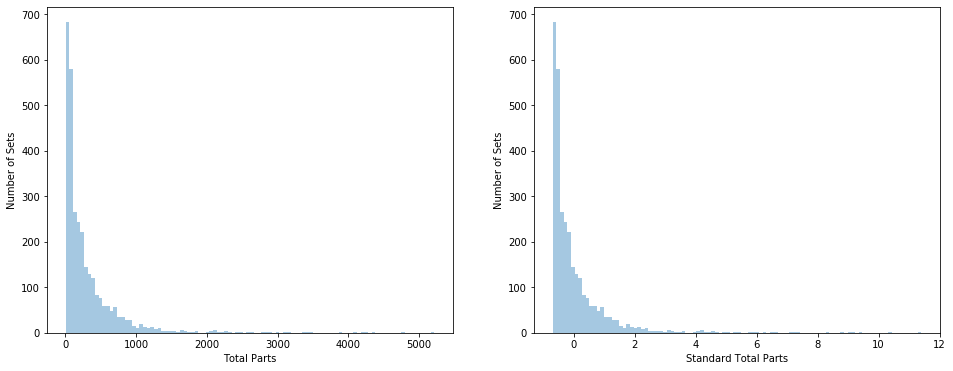

In [13]:
fig, axs = MP.subplots(1, 2, figsize=(16, 6))
parts_idx = X_train.columns.get_loc('total_parts')

SB.distplot(X_train['total_parts'], ax=axs[0], kde=False, bins=100)
axs[0].set(xlabel='Total Parts', ylabel='Number of Sets')

SB.distplot(X_train_std[:, parts_idx], ax=axs[1], kde=False, bins=100)
axs[1].set(xlabel='Standard Total Parts', ylabel='Number of Sets')

MP.show()

## Logistic Regression

In [14]:
# setup for several algorithms

MAX_ITER = 10000
algorithm_ls = []
alpha_ls = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

In [15]:
# lbfgs standalone 

logreg = LM.LogisticRegression(solver='lbfgs', penalty='none', max_iter=MAX_ITER)
logreg.fit(X_train_std, y_train)
logreg.score(X_train_std, y_train)

0.8022838499184339

In [16]:
# use cross validation to evaluate algorithm

logreg_cv = LM.LogisticRegression(solver='lbfgs', penalty='none', max_iter=MAX_ITER)
cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
cv_results

{'fit_time': array([0.38463688, 0.45589709, 0.36346889, 0.3222611 , 0.41892314]),
 'score_time': array([0.00075006, 0.00062013, 0.00060892, 0.00095677, 0.00067186]),
 'test_score': array([0.79478827, 0.75203915, 0.76508972, 0.76019576, 0.77614379]),
 'train_score': array([0.8000816 , 0.8091354 , 0.80750408, 0.80587276, 0.80513657])}

In [17]:
# compile algorithm results
# ok to use non-adjusted r-sq, use adjusted just for final test

new_dx = {
    'type': 'lbfgs',
    'lambda': NP.min(alpha_ls) - 0.5 *NP.min(alpha_ls), 
    'cvtrain_score': cv_results['train_score'].mean(),
    'cvtrain_error': cv_results['train_score'].std(),
    'cvtest_score': cv_results['test_score'].mean(),
    'cvtest_error': cv_results['test_score'].std(),
}
algorithm_ls.append(new_dx)
new_dx

{'type': 'lbfgs',
 'lambda': 0.0005,
 'cvtrain_score': 0.8055460803451776,
 'cvtrain_error': 0.003061108956355994,
 'cvtest_score': 0.7696513394836,
 'cvtest_error': 0.014794748384436463}

In [18]:
# liblinear with L1 standalone 

logreg = LM.LogisticRegression(solver='liblinear', penalty='l1', C=.1, max_iter=MAX_ITER)
logreg.fit(X_train_std, y_train)
logreg.score(X_train_std, y_train)

0.7918433931484502

In [19]:
# saga with L1 standalone 
# it's nearly identical to liblinear

logreg = LM.LogisticRegression(solver='saga', penalty='l1', C=.1, max_iter=MAX_ITER)
logreg.fit(X_train_std, y_train)
logreg.score(X_train_std, y_train)

0.7924959216965742

In [20]:
# liblinear with L1

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='liblinear', penalty='l1', C=1/alpha, max_iter=MAX_ITER)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'liblinear-L1',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [21]:
# saga with L1

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='saga', penalty='l1', C=1/alpha, max_iter=MAX_ITER)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'saga-L1',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [22]:
# liblinear with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='liblinear', penalty='l2', C=1/alpha, max_iter=MAX_ITER)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'liblinear-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [23]:
# newton with L2
# this is exactly the same as saga with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='newton-cg', penalty='l2', C=1/alpha, max_iter=MAX_ITER)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'newtoncg-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [24]:
# sag with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='sag', penalty='l2', C=1/alpha, max_iter=MAX_ITER)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'sag-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

In [25]:
# saga with L2

for alpha in alpha_ls:
    
    logreg_cv = LM.LogisticRegression(solver='saga', penalty='l2', C=1/alpha, max_iter=MAX_ITER)
    cv_results = MS.cross_validate(logreg_cv, X_train_std, y_train, cv=5, return_train_score=True)
    
    new_dx = {
        'type': 'saga-L2',
        'lambda': alpha,
        'cvtrain_score': cv_results['train_score'].mean(),
        'cvtrain_error': cv_results['train_score'].std(),
        'cvtest_score': cv_results['test_score'].mean(),
        'cvtest_error': cv_results['test_score'].std(),
    }
    algorithm_ls.append(new_dx)

## Compare Algorithms

In [26]:
algorithm_df = PD.DataFrame(algorithm_ls)
algorithm_df.head()

,cvtest_error,cvtest_score,cvtrain_error,cvtrain_score,lambda,type
0,0.014795,0.769651,0.003061,0.805546,0.0005,lbfgs
1,0.014605,0.771611,0.002812,0.805220,0.0010,liblinear-L1
2,0.013996,0.770959,0.002962,0.805138,0.0100,liblinear-L1
3,0.014207,0.771611,0.002373,0.805383,0.1000,liblinear-L1
4,0.012374,0.775197,0.003701,0.804730,1.0000,liblinear-L1


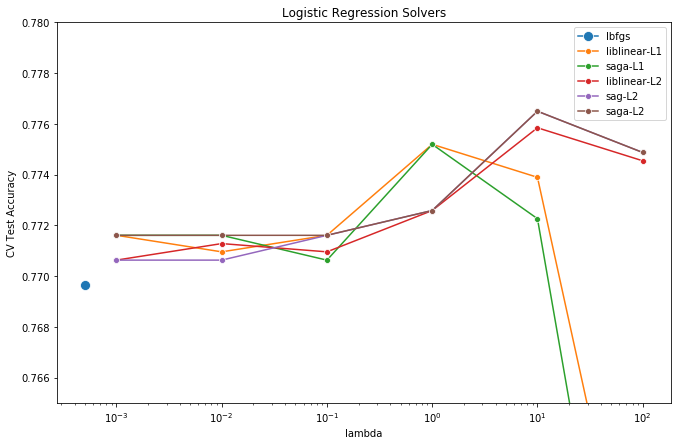

In [29]:
fig, axs = MP.subplots(1, 1, figsize=(11, 7), facecolor='white')


baseline_df = algorithm_df.loc[algorithm_df['type']=='lbfgs']
SB.lineplot(data=baseline_df, x='lambda', y='cvtest_score', marker='o', ax=axs, 
            label='lbfgs', markersize=10)

regular11_df = algorithm_df.loc[algorithm_df['type']=='liblinear-L1']
SB.lineplot(data=regular11_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='liblinear-L1')

regular12_df = algorithm_df.loc[algorithm_df['type']=='saga-L1']
SB.lineplot(data=regular12_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='saga-L1')

regular21_df = algorithm_df.loc[algorithm_df['type']=='liblinear-L2']
SB.lineplot(data=regular21_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='liblinear-L2')

regular23_df = algorithm_df.loc[algorithm_df['type']=='sag-L2']
SB.lineplot(data=regular23_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='sag-L2')

regular24_df = algorithm_df.loc[algorithm_df['type']=='saga-L2']
SB.lineplot(data=regular24_df, x='lambda', y='cvtest_score', marker='o', ax=axs,
           label='saga-L2')


axs.set(title='Logistic Regression Solvers', xlabel='lambda', ylabel='CV Test Accuracy', 
        xscale='log', ylim=(0.765, 0.78) )
axs.set_xticks(alpha_ls)

MP.show()

## Best Algorithm

In [31]:
# redo with grid-search

SEED = 666
sampler = OS.SMOTE(random_state=SEED)
scaler = PP.StandardScaler()
logreg_best = LM.LogisticRegression(solver='saga', penalty='l2', max_iter=MAX_ITER, random_state=SEED)
pipeline = PL.Pipeline([('sampler', sampler), ('transformer', scaler), ('estimator', logreg_best)])

param_dx = {
    'estimator__C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
    }

searcher = MS.GridSearchCV(pipeline, param_dx, scoring='accuracy', cv=5)

In [32]:
# run the grid search

searcher.fit(X_train, y_train);

In [36]:
# check the best parameters found by grid search

best_parameters = searcher.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

train_pred = searcher.predict(X_train)
train_accuracy = MT.accuracy_score(y_train, train_pred)
test_pred = searcher.predict(X_test)
test_accuracy = MT.accuracy_score(y_test, test_pred)

print("")
print("Training Accuracy: {:.4}%".format(train_accuracy * 100))
print("")
print("Validation Accuracy: {:.4}%".format(test_accuracy * 100))

guess_TP = 0
guess_TN = len(y_test[y_test==0])
guess_FP = 0
guess_FN = len(y_test[y_test==1])

print("")
print("Random Guess Accuracy: {:.4}%".format( 
    (guess_TP + guess_TN) / (guess_TP + guess_TN + guess_FP + guess_FN) * 100))

Grid Search found the following optimal parameters: 
estimator__C: 10000.0

Training Accuracy: 78.83%

Validation Accuracy: 77.57%

Random Guess Accuracy: 74.97%


In [37]:
# now run with balanced test set

undersampler = US.RandomUnderSampler()
X_test_under, y_test_under = undersampler.fit_resample(X_test, y_test)
X_test_under.shape
y_test_under.shape

(384,)

In [38]:
train_pred = searcher.predict(X_train)
train_accuracy = MT.accuracy_score(y_train, train_pred)
test_pred = searcher.predict(X_test_under)
test_accuracy = MT.accuracy_score(y_test_under, test_pred)

print("")
print("Training Accuracy: {:.4}%".format(train_accuracy * 100))
print("")
print("Validation Accuracy: {:.4}%".format(test_accuracy * 100))

guess_TP = 0
guess_TN = len(y_test_under[y_test_under==0])
guess_FP = 0
guess_FN = len(y_test_under[y_test_under==1])

print("")
print("Random Guess Accuracy: {:.4}%".format( 
    (guess_TP + guess_TN) / (guess_TP + guess_TN + guess_FP + guess_FN) * 100))


Training Accuracy: 78.83%

Validation Accuracy: 67.71%

Random Guess Accuracy: 50.0%
